In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
import wandb

from src.net import InstanceGCN
from src.dataset import MultiTargetDataset
from src.utils import load_from_wandb

In [3]:
api = wandb.Api()
run = api.run('brunompac/sat-gnn/y8klzrnk')
df = run.history()
df['relative_obj'] = df['relative_obj'].astype(float)
df

,_runtime,gap,infeasible,rel_primal_integral,_step,n_fixed,relative_obj,obj,primal_curve,runtime,_timestamp,pd_integral
0,215.991334,0.000244,0,2.462847,0,0,1.000000,7013.0,"{'ncols': 2, 'nrows': 30197, 'path': 'media/ta...",120.000130,1.689093e+09,111334.877780
1,337.238018,0.000164,0,0.955566,1,200,1.000000,7013.0,"{'ncols': 2, 'nrows': 39278, 'path': 'media/ta...",120.000970,1.689093e+09,173914.646235
2,344.213045,0.000000,0,0.914817,2,500,0.996578,6989.0,"{'nrows': 136, 'path': 'media/table/primal_cur...",6.673077,1.689093e+09,131682.524929
3,344.976354,0.000244,1,2.462847,3,1000,1.000000,7013.0,{'sha256': '7063b529a9565f9674b3a563c518015d10...,120.010897,1.689093e+09,111334.877780
4,465.395165,0.016008,0,4.433317,4,0,1.000000,6525.0,"{'_type': 'table-file', 'ncols': 2, 'nrows': 3...",120.000478,1.689093e+09,176599.880274
...,...,...,...,...,...,...,...,...,...,...,...,...
475,40864.083416,0.000000,1,0.316933,475,1000,1.000000,3782.0,"{'ncols': 2, 'nrows': 8, 'path': 'media/table/...",3.258838,1.689134e+09,122893.006399
476,40882.090179,0.000000,0,0.130260,476,0,1.000000,3972.0,"{'_type': 'table-file', 'ncols': 2, 'nrows': 1...",17.643368,1.689134e+09,33328.942524
477,40882.380079,0.000000,1,0.130260,477,200,1.000000,3972.0,{'path': 'media/table/primal_curve_477_6944a84...,17.650331,1.689134e+09,33328.942524
478,40882.685353,0.000000,1,0.130260,478,500,1.000000,3972.0,{'_latest_artifact_path': 'wandb-client-artifa...,17.649452,1.689134e+09,33328.942524


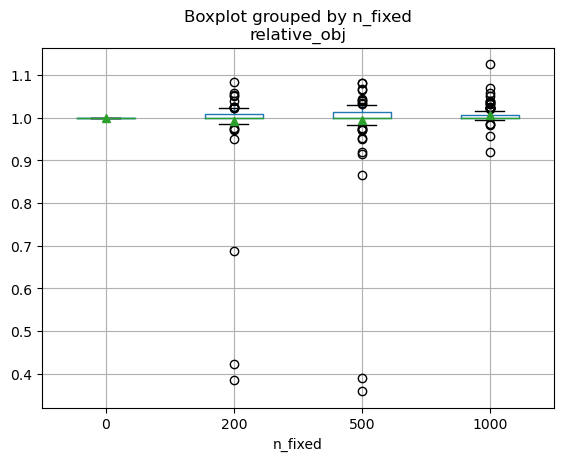

In [4]:
df.boxplot(column='relative_obj', by='n_fixed', showmeans=True)
plt.show()

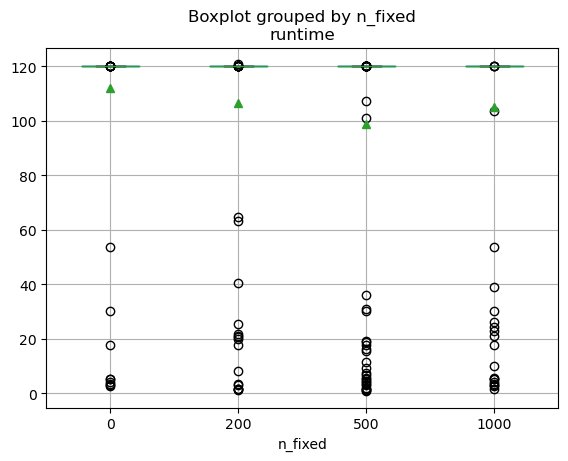

In [5]:
df.boxplot(column='runtime', by='n_fixed', showmeans=True)
plt.show()

In [6]:
import json
import pandas as pd

def load_table(i: int):
    try:
        table_dir = run.logged_artifacts()[i].download()
    except IndexError:
        return np.nan

    table_path = f"{table_dir}/primal_curve.table.json"
    try:
        with open(table_path) as file:
            json_dict = json.load(file)

        table = pd.DataFrame(json_dict["data"], columns=json_dict["columns"])
        return table.values
    except:
        return np.nan

# df['primal_curve'] = df.iloc[:95]['_step'].apply(load_table)
# df['primal_curve'] = df.iloc[:-1]['_step'].apply(load_table)
df['primal_curve'] = df['_step'].apply(load_table)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files dow

In [9]:
# df.to_pickle('run_history_y8klzrnk.pkl')
df = pd.read_pickle('run_history_7ijh7dwq.pkl')

In [10]:
df.loc[:,'n_fixed'][df['n_fixed'] > 1000] = 'all'

/tmp/ipykernel_873298/3442813273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'n_fixed'][df['n_fixed'] > 1000] = 'all'


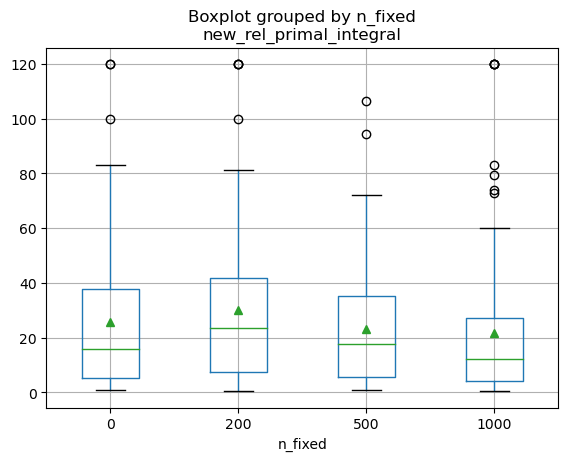

In [8]:
T = run.config['ef_time_budget']
timestep = .001
standard_range = pd.to_timedelta(np.linspace(0,T,int(T/timestep) +1), 's')
def normalize_timeseries(curve):
    if np.isnan(curve).any():
        return np.nan
    else:
        c = pd.Series(curve[:,1], index=pd.to_timedelta(curve[:,0], 's'))
        c = c.reindex(standard_range, method='ffill')
        return c.values

def compute_integral(curve):
    if np.isnan(curve).any():
        return np.nan
    else:
        return T - timestep * curve.sum()

df['normalized_primal_curve'] = df['primal_curve'].apply(normalize_timeseries)
df['new_rel_primal_integral'] = df['normalized_primal_curve'].apply(compute_integral)

df.boxplot(column='new_rel_primal_integral', by='n_fixed', showmeans=True)
plt.show()

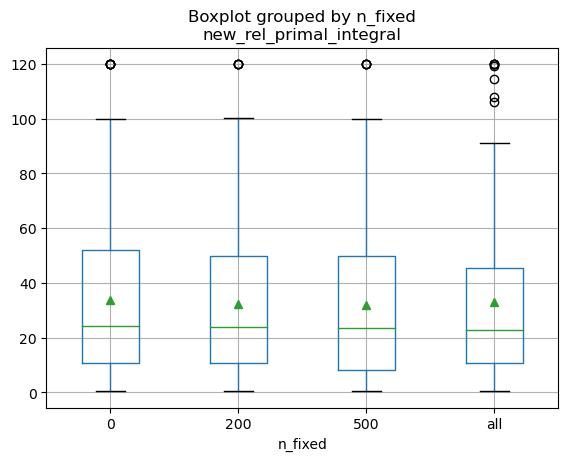

In [11]:
T = run.config['ef_time_budget']
timestep = .001
standard_range = pd.to_timedelta(np.linspace(0,T,int(T/timestep) +1), 's')
def normalize_timeseries(curve):
    if np.isnan(curve).any():
        return np.nan
    else:
        c = pd.Series(curve[:,1], index=pd.to_timedelta(curve[:,0], 's'))
        c = c.reindex(standard_range, method='ffill')
        return c.values

def compute_integral(curve):
    if np.isnan(curve).any():
        return np.nan
    else:
        return T - timestep * curve.sum()

df['normalized_primal_curve'] = df['primal_curve'].apply(normalize_timeseries)
df['new_rel_primal_integral'] = df['normalized_primal_curve'].apply(compute_integral)

df.boxplot(column='new_rel_primal_integral', by='n_fixed', showmeans=True)
plt.show()

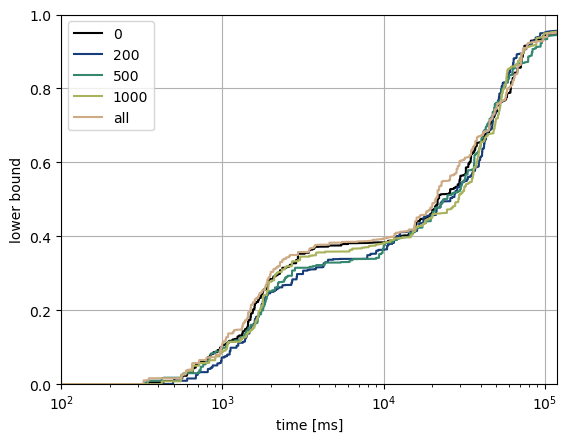

In [36]:
cmap = plt.get_cmap('gist_earth')
for n in df['n_fixed'].unique():
    mean_curve = 0
    n_curves = 0
    for curve in df[df['n_fixed'] == n]['normalized_primal_curve'].iloc:
        if not curve is np.nan:
            mean_curve += curve
            n_curves += 1

    mean_curve = mean_curve / n_curves

    if n == 'all':
        color = cmap(1250/1500)
    else:
        color = cmap(n / 1500)
    plt.plot(mean_curve, c=color, label=n)

plt.ylabel('lower bound')
plt.xlabel('time [ms]')
plt.ylim(0,1)
plt.xlim(.1*1e3,T*1e3)
plt.xscale('log')
# plt.xlim(0,10*1e3)
plt.grid()
plt.legend()
plt.show()

In [8]:
df = pd.read_pickle('run_history.pkl')

In [28]:
_df['n_fixed']

0         0
1       200
2       500
3      2522
4         0
       ... 
475    1746
476       0
477     200
478     500
479    1746
Name: n_fixed, Length: 480, dtype: int64

/tmp/ipykernel_873298/2064444436.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.loc[:,'n_fixed'][_df['n_fixed'] > 1000] = 'all'
/tmp/ipykernel_873298/2064444436.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.loc[:,'n_fixed'][_df['n_fixed'] > 1000] = 'all'
/tmp/ipykernel_873298/2064444436.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.loc[:,'n_fixed'][_df['n_fixed'] > 1000] = 'all'


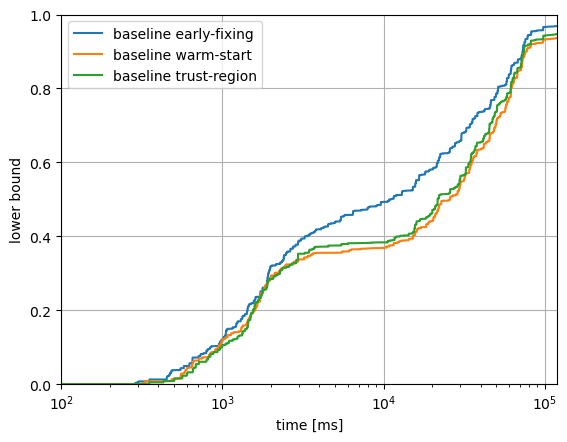

In [13]:
T = run.config['ef_time_budget']
timestep = .001
standard_range = pd.to_timedelta(np.linspace(0,T,int(T/timestep) +1), 's')
def normalize_timeseries(curve):
    if np.isnan(curve).any():
        return np.nan
    else:
        c = pd.Series(curve[:,1], index=pd.to_timedelta(curve[:,0], 's'))
        c = c.reindex(standard_range, method='ffill')
        return c.values

def compute_integral(curve):
    return T - timestep * curve.sum()

approaches_ids = {
    'early-fixing': (500, 'y8klzrnk'),
    'warm-start': ('all', '7ijh7dwq'),
    'trust-region': (1000, '9uynfotl'),
}

for approach, (n, rid) in approaches_ids.items():
    _df = pd.read_pickle(f'run_history_{rid}.pkl')

    _df['normalized_primal_curve'] = _df['primal_curve'].apply(normalize_timeseries)
    _df.loc[:,'n_fixed'][_df['n_fixed'] > 1000] = 'all'

    mean_curve = 0
    n_curves = 0
    for curve in _df[_df['n_fixed'] == 0]['normalized_primal_curve'].iloc:
        if not curve is np.nan:
            mean_curve += curve
            n_curves += 1
    mean_curve = mean_curve / n_curves

    plt.plot(mean_curve, label='baseline '+approach)

plt.ylabel('lower bound')
plt.xlabel('time [ms]')
plt.ylim(0,1)
plt.xlim(.1*1e3,T*1e3)
plt.xscale('log')
# plt.xlim(0,10*1e3)
plt.grid()
plt.legend()
plt.show()

/tmp/ipykernel_873298/3717588058.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.loc[:,'n_fixed'][_df['n_fixed'] > 1000] = 'all'
/tmp/ipykernel_873298/3717588058.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.loc[:,'n_fixed'][_df['n_fixed'] > 1000] = 'all'
/tmp/ipykernel_873298/3717588058.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.loc[:,'n_fixed'][_df['n_fixed'] > 1000] = 'all'


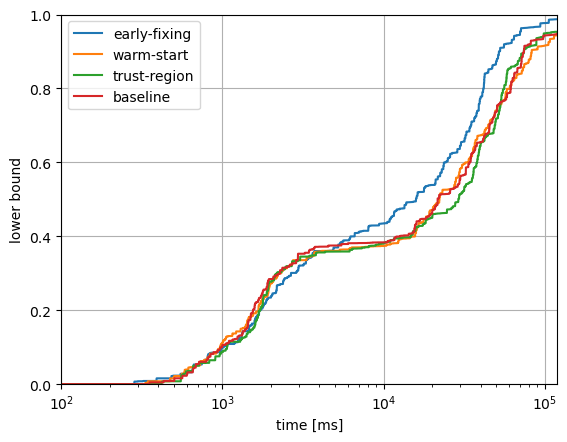

In [ ]:
T = run.config['ef_time_budget']
timestep = .001
standard_range = pd.to_timedelta(np.linspace(0,T,int(T/timestep) +1), 's')
def normalize_timeseries(curve):
    if np.isnan(curve).any():
        return np.nan
    else:
        c = pd.Series(curve[:,1], index=pd.to_timedelta(curve[:,0], 's'))
        c = c.reindex(standard_range, method='ffill')
        return c.values

def compute_integral(curve):
    return T - timestep * curve.sum()

approaches_ids = {
    'early-fixing': (500, 'y8klzrnk'),
    'warm-start': ('all', '7ijh7dwq'),
    'trust-region': (1000, '9uynfotl'),
}

for approach, (n, rid) in approaches_ids.items():
    _df = pd.read_pickle(f'run_history_{rid}.pkl')

    _df['normalized_primal_curve'] = _df['primal_curve'].apply(normalize_timeseries)
    _df.loc[:,'n_fixed'][_df['n_fixed'] > 1000] = 'all'

    mean_curve = 0
    n_curves = 0
    for curve in _df[_df['n_fixed'] == n]['normalized_primal_curve'].iloc:
        if not curve is np.nan:
            mean_curve += curve
            n_curves += 1
    mean_curve = mean_curve / n_curves

    plt.plot(mean_curve, label=approach)

mean_curve = 0
n_curves = 0
for curve in _df[_df['n_fixed'] == 0]['normalized_primal_curve'].iloc:
    if not curve is np.nan:
        mean_curve += curve
        n_curves += 1
mean_curve = mean_curve / n_curves
plt.plot(mean_curve, label='baseline')

plt.ylabel('lower bound')
plt.xlabel('time [ms]')
plt.ylim(0,1)
plt.xlim(.1*1e3,T*1e3)
plt.xscale('log')
# plt.xlim(0,10*1e3)
plt.grid()
plt.legend()
plt.show()

In [18]:
model_run_id = 'lhu19g7l'
project = 'sat-gnn'

# restore model
net = InstanceGCN(readout_op=None)  # TODO: initialize net following run's config

model_run = wandb.init(project=project, id=model_run_id)
model_config = model_run.config
model_group = model_run.group
model_file = model_run.restore('model_last.pth', replace=True)
model_run.finish()

net.load_state_dict(torch.load(model_file.name))
net.eval()

run = wandb.init(project='sat-gnn', group=model_group, job_type='early-fixing-eval', config=dict(
    model_run_id=model_run_id,
    **model_config
))

In [19]:
instances_fpaths = list(Path('../data/raw/').glob('97_24*.json'))

run.config['test_instances'] = [fp.name for fp in instances_fpaths]

dataset = MultiTargetDataset(
    instances_fpaths=instances_fpaths,
    sols_dir='/home/bruno/sat-gnn/data/interim',
    split='val',
    return_model=True,
)
len(dataset)

KeyboardInterrupt: 

In [ ]:
from src.problem import ModelWithPrimalDualIntegral


def evaluate_early_fixing(model, fixed_vars: dict = None, timeout=10,
                            hide_output=True):
    model_ = ModelWithPrimalDualIntegral(sourceModel=model)
    model_.setParam('limits/time', timeout)
    model_.hideOutput(hide_output)

    if fixed_vars is not None:
        for var in model_.getVars():
            try:
                fixed_var_X = fixed_vars[var.name]
                model_.fixVar(var, fixed_var_X)
            except KeyError:
                pass

    model_.optimize()

    if model_.getStatus().lower() not in ['optimal', 'timelimit']:
        infeasible = True
        runtime = model_.getSolvingTime()
        objective = 0
        gap = -1
        primal_dual_integral = -1
    else:
        infeasible = False
        runtime = model_.getSolvingTime()
        try:
            objective = model_.getObjVal()
            gap = model_.getGap()
            primal_dual_integral = model_.get_primal_dual_integral()
        except:
            # in case the problem is not infeasible but not solution was
            # found during the time limit
            objective = 0
            gap = -1
            primal_dual_integral = -1

    return infeasible, runtime, objective, gap, primal_dual_integral

In [ ]:
# N = [0, 50, 100, 200, 500, 1000, -1]
N = [0, 50, 100, 500]
# time_budget = 10 * 60  # 10 min
time_budget = 10  # 10 s

run.config['N'] = N
run.config['ef_time_budget'] = time_budget

for graph, model in dataset:
    # TODO: device!

    vars_names = np.core.defchararray.array([v.name for v in model.getVars()])
    vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]

    # baseline results
    (
        baseline_infeasible,
        baseline_runtime,
        baseline_obj,
        baseline_gap,
        baseline_pd_integral
    ) = evaluate_early_fixing(model, None, time_budget)

    if baseline_infeasible:
        print('INFEASIBLE PROBLEM')
        print(model)
        continue

    with torch.set_grad_enabled(False):
        x_hat = net.get_candidate(graph).flatten().cpu()
        x_hat = x_hat[:len(vars_names)]  # drop zetas

    most_certain_idx  = (x_hat - 0.5).abs().sort(descending=True).indices

    for i in range(len(N)):
        n = N[i] if N[i] >= 0 else len(x_hat)

        if n == 0:
            result = {
                'infeasibles': 0,
                'runtimes': baseline_runtime,
                'objs': baseline_obj,
                'gaps': baseline_gap,
                'pd_integrals': baseline_pd_integral,
            }
            run.log(
                dict(n_fixed=n, **result)
            )
            continue

        fixed_x_hat = (x_hat[most_certain_idx[:n]] > .5).to(x_hat)
        fixed_vars_names = vars_names[most_certain_idx[:n]]
        fixed_vars = dict(zip(fixed_vars_names, fixed_x_hat))

        (
            infeasible, runtime, obj, gap, pd_integral
        ) = evaluate_early_fixing(model, fixed_vars, time_budget)

        if infeasible:
            result = {
                'runtimes': baseline_runtime + runtime,
                'objs': baseline_obj,
                'gaps': baseline_gap,
                'pd_integrals': baseline_pd_integral,
            }
        else:
            result = {
                'runtimes': runtime,
                'objs': obj,
                'gaps': gap,
                'pd_integrals': pd_integral,
            }
        result['infeasibles'] = int(infeasible)

        run.log(
            dict(n_fixed=n, **result)
        )


In [ ]:
wandb.finish()

gaps,▁▁██████▁▁▁███████▁▁██▁▁██████▁▁▁▁██▁▁██
infeasibles,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_fixed,▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁█
objs,▂▁██████▂▂▂███████▂▂██▁▁██████▂▂▁▃██▁▁██
pd_integrals,▆▆▁▁▁▁▁▁▆▅▇▁▁▁▁▁▁▁▇▆▁▁█▇▁▁▁▁▁▁▇▇█▄▁▁██▁▁
runtimes,▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▆▁▂▁▂▁▃▁▄▂█▁▂▃▂▂▄▃▅▁▁▂▁▂▁
gaps,1e+20
infeasibles,0
n_fixed,500
objs,27576.0
pd_integrals,100147.24
